In [48]:
import numpy as np
import pandas as pd
import graspologic as gs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.simulations import sbm
from graspologic.utils import remove_vertices
from graspologic.plot import pairplot, heatmap

np.random.seed(9002)
np.set_printoptions(suppress=True)

# Make 2D

In [7]:
# create sbm
def graph(P, directed=False, diag_aug=False, reverse_pred=False, suppress_text=False, n=100, title=None):
    n_components = P.shape[0]
    ase = ASE(n_components=n_components, diag_aug=diag_aug)
    directed_g, labels = sbm([n]*n_components, P, 
                           return_labels=True, directed=directed)

    # generate labels
    oos_idx = np.nonzero(np.r_[1, np.diff(labels)[:-1]])[0]  # grab one from each community
    labels = list(labels)
    oos_labels = [labels.pop(i) for i in oos_idx]

    # grab oos indices
    A, a = remove_vertices(directed_g, indices=oos_idx, return_removed=True)
    print(f"A is type {type(A)}")

    if directed:
        latent_left, latent_right = ase.fit_transform(A)
    else:
        latent_left = ase.fit_transform(A)

    if reverse_pred and directed:
        w = ase.transform(a[::-1])
    else:
        w = ase.transform(a)
    
    if directed:
        print(f"w should be a tuple. w is type {type(w)}")
        w_left, w_right = w
    else:
        w_left = w

    # print results
    if not suppress_text:
        print(f"left latent positions (sample from same communities): \n{latent_left[oos_idx, :]}\n")
        print(f"left prediction: \n{w_left}\n\n")
        
        if directed:
            print(f"right latent positions (sample from same communities): \n{latent_right[oos_idx, :]}\n")
            print(f"right prediction: \n{w_right}")
    
    # labels dataframes
    df_labels = pd.DataFrame(labels, columns=["Type"])
    df_oos_labels = pd.DataFrame(oos_labels, columns=["Type"])

    # left dataframes
    out_oos_df = pd.concat([df_oos_labels, pd.DataFrame(w_left)], axis=1)
    out_oos_df.columns = ["Type"]+[f"Dimension {d+1}" for d in range(P.shape[0])]

    g = pairplot(latent_left, labels=labels, title=title + ", Out" if title else None)
    g.data = out_oos_df
    g.hue_vals = out_oos_df["Type"]
    g.map_offdiag(plt.scatter, s=500, marker="*", edgecolor="black")
    
    # in dataframes
    if directed:
        in_oos_df = pd.concat([df_oos_labels, pd.DataFrame(w_right)], axis=1)
        in_oos_df.columns = ["Type"]+[f"Dimension {d+1}" for d in range(P.shape[0])]

        h = pairplot(latent_right, labels=labels, title=title + ", In" if title else None)
        h.data = in_oos_df
        h.hue_vals = in_oos_df["Type"]
        h.map_offdiag(plt.scatter, s=500, marker="*", edgecolor="black")

In [60]:
P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])

ase = ASE(n_components=3)
directed_g, labels = sbm([200]*3, P, 
                       return_labels=True, directed=True)

# generate labels
oos_idx = np.nonzero(np.r_[1, np.diff(labels)[:-1]])[0]  # grab one from each community
labels = list(labels)
oos_labels = [labels.pop(i) for i in oos_idx]

# grab oos indices
A, a = remove_vertices(directed_g, indices=oos_idx, return_removed=True)

# transform
latent_left, latent_right = ase.fit_transform(A)
w_left, w_right = ase.transform(a)

df_left = pd.DataFrame({"Type": labels, 
                       "Dimension 1": latent_left[:, 0],
                       "Dimension 2": latent_left[:, 1],
                       "Dimension 3": latent_left[:, 2]})
means_left = df_left.groupby("Type").mean()

distances_left = np.diag(pairwise_distances(means_left, w_left))
distances_right = np.diag(pairwise_distances(means_left, w_right))

print(distances_left)
print(distances_right)

[0.020646   0.0923907  0.13977686]
[0.13265417 0.3325543  0.27638723]


In [63]:
all(distances_left < distances_right)

True

## with first array

A is type <class 'numpy.ndarray'>
left latent positions (sample from same communities): 
[[ 0.71505795 -0.57751888]
 [ 0.61686268  0.55151876]]

left prediction: 
[[ 0.72642811 -0.50738069]
 [ 0.71544086  0.55606625]]




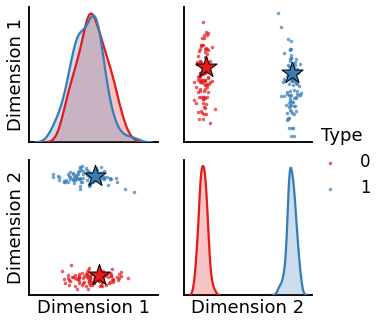

In [8]:
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

graph(P, directed=False)

In [9]:
P.shape[0]
[f"Dimension {d+1}" for d in range(P.shape[0])]

['Dimension 1', 'Dimension 2']

## with second array

anton says: if it aint positive semidefinite, it aint gon work

A is type <class 'numpy.ndarray'>
left latent positions (sample from same communities): 
[[ 0.75487769 -0.55073338]
 [ 0.6341101   0.52781559]]

left prediction: 
[[ 0.65831694  0.57920327]
 [ 0.69245478 -0.48785124]]




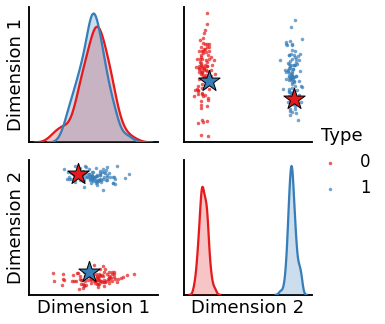

In [10]:
P = np.array([[0.2, 0.8],
              [0.8, 0.2]])

graph(P, directed=False)

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
left latent positions (sample from same communities): 
[[ 0.72763923  0.45097228]
 [ 0.67481038 -0.5143663 ]]

left prediction: 
[[ 0.76055     0.5594927 ]
 [ 0.6895756  -0.59348069]]


right latent positions (sample from same communities): 
[[ 0.70303092 -0.5846459 ]
 [ 0.68724718  0.54866663]]

right prediction: 
[[ 0.63754609 -0.54134047]
 [ 0.71412548  0.52467801]]


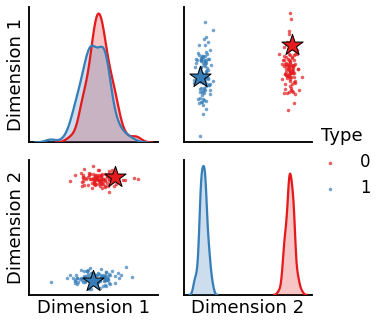

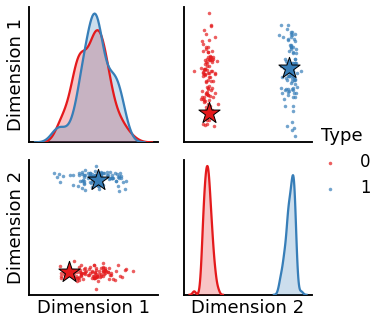

In [11]:
graph(P, directed=True)

In [12]:
# its because there's a negative eigenvalue
np.linalg.eig(P)

(array([ 1. , -0.6]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

## 3D

#### undirected case

In [ ]:
P = np.array([[0.8, 0.3, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.1, 0.6]])

# P = np.array([[0.9, 0.1, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=False, diag_aug=True, suppress_text=True, n=n, title=f"n={n}")
    
# print(np.linalg.eig(P))

#### directed case

A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
A is type <class 'numpy.ndarray'>
w should be a tuple. w is type <class 'tuple'>
(array([1.08844837, 0.58842506, 0.42312657]), array([[-0.59752807, -0.31739708, -0.13330639],
       [-0.49598508,  0.04154763, -0.30671662],
       [-0.63004683,  0.94738212,  0.9424194 ]]))


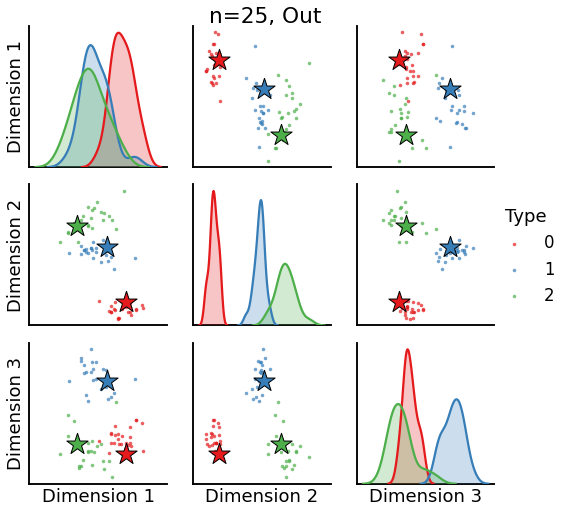

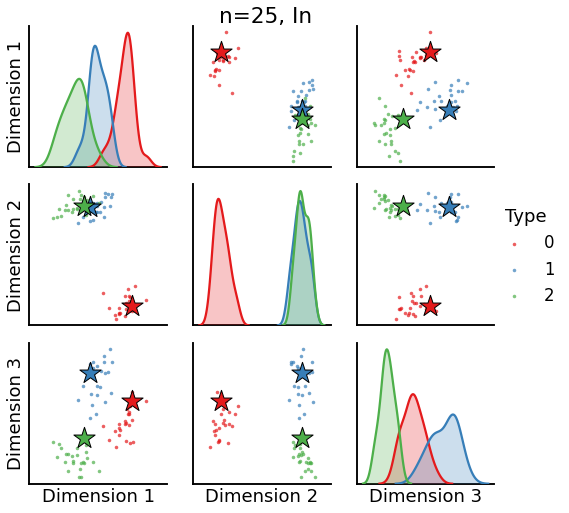

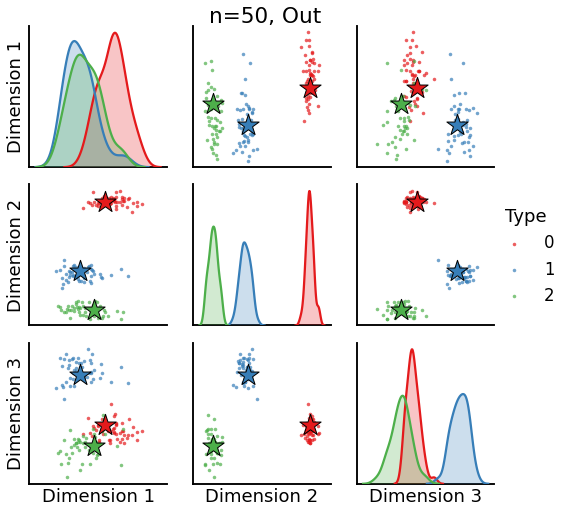

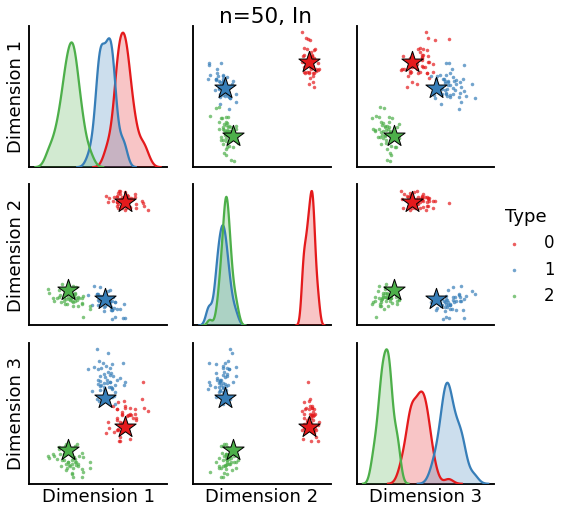

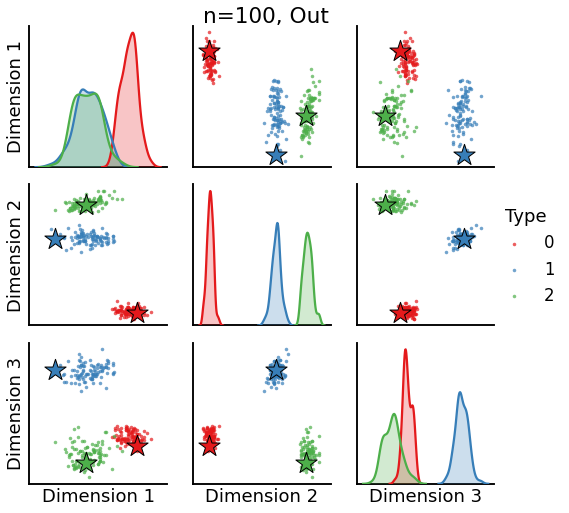

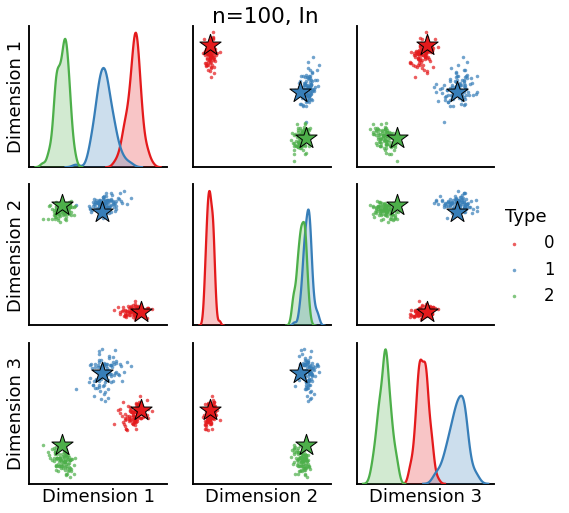

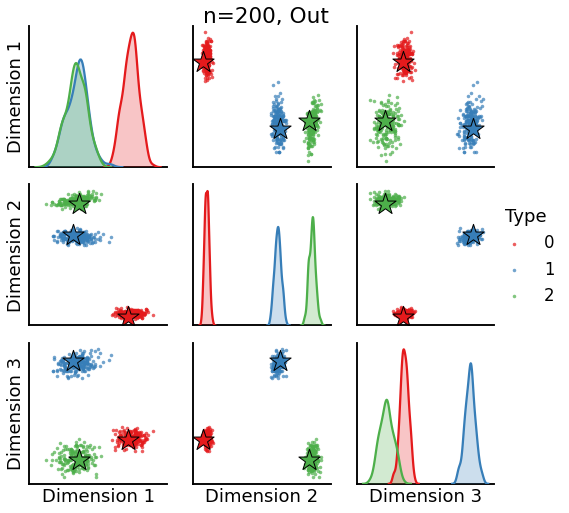

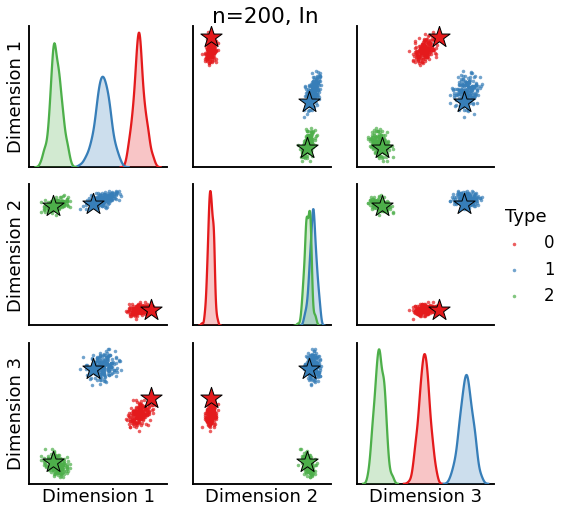

In [13]:
# P = np.array([[0.8, 0.3, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.1, 0.6]])

P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=True, diag_aug=True, suppress_text=True, n=n, title=f"n={n}")
    
print(np.linalg.eig(P))

#### directed case (no diagonal augmentation)

In [ ]:
# P = np.array([[0.8, 0.3, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.1, 0.6]])

P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=True, diag_aug=False, suppress_text=True, n=n, title=f"n={n}")
    
print(np.linalg.eig(P))

In [ ]:
# P = np.array([[0.8, 0.3, 0.1], 
#               [0.3, 0.6, 0.1], 
#               [0.1, 0.1, 0.6]])

P = np.array([[0.9, 0.1, 0.1], 
              [0.3, 0.6, 0.1], 
              [0.1, 0.5, 0.6]])


for n in [25, 50, 100, 200]:
    graph(P, directed=True, diag_aug=False, reverse_pred=False, suppress_text=True, n=n, title=f"n={n}")
    graph(P, directed=True, diag_aug=False, reverse_pred=True, suppress_text=True, n=n, title=f"n={n}, oos vertices reversed order")
    
print(np.linalg.eig(P))

In [ ]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

??ASE